In [1]:
%matplotlib inline

import sys
import os
sys.path.append("../..")

import numpy as np
import re
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import exposure, img_as_float, morphology, color
from skimage.measure import label
from sklearn.model_selection import KFold
from PIL import Image
import xml.etree.ElementTree as ET

from osgeo import gdal
import osr
import my_packages.My_Geoprocess as mgp


In [ ]:
class LyzengaMod:
    
    """Classe définissant un model bathymetrique de type lyzenga.
    
    Elle possède comme attributs :
    H -- Un ensemble de parametre
    Score -- Un score
    """
    from sklearn.metrics import r2_score


        
    def fit(self, lnX, Y):
        assert lnX.shape[0] == Y.shape[0]
        
        lnX = np.hstack((np.ones((lnX.shape[0],1)), lnX))
        self.Parameters = np.linalg.solve(lnX.T.dot(lnX), lnX.T.dot(Y))
        
        ecart = lnX.dot(self.Parameters) - Y
        N = len(ecart)
        self.score = {'averageDev':np.sum(ecart)/N, 'Var':np.sum(np.square(ecart))/N,'RMS':np.sum(np.sqrt(ecart**2))/N, 'Error%':np.mean(np.abs(ecart)/Y), 'Error':np.sum(np.abs(ecart)), 'R2': r2_score(Y, lnX.dot(self.Parameters))}
        
    def fit2(self, lnX, Y):
        assert lnX.shape[0] == Y.shape[0]
        print('ok')
        
    def predict(self, lnX):
        
        lnX = np.hstack((np.ones((lnX.shape[0],1)), lnX))
        assert lnX.shape[1] == self.Parameters.shape[0]
        
        return lnX.dot(self.Parameters)
    
    def predictEval(self, lnX, Y):
        
        assert lnX.shape[0] == Y.shape[0]
        lnX = np.hstack((np.ones((lnX.shape[0],1)), lnX))
        
        ecart = lnX.dot(self.Parameters) - Y
        N = len(ecart)
        self.Testscore = {'averageDev':np.sum(ecart)/N, 'Var':np.sum(np.square(ecart))/N,'RMS':np.sum(np.sqrt(ecart**2))/N, 'Error%':np.mean(np.abs(ecart)/Y),'Error':np.sum(np.abs(ecart)), 'R2': r2_score(Y, lnX.dot(self.Parameters))}
        
         
        return lnX.dot(self.Parameters)
    
    def __init__(self):
        """Constructeur de notre personne."""
        self.Parameters = np.array
        self.score = {}
        self.Testscore = {}

In [2]:
ClassifFolder = '../../Poe/Resultats/Classifications/'
ImagesFolder = '../../Poe/Images/Acolyte/S2A_MSIL1C_20180305T230901_N0206_R101_T58KEB_20180306T00234_bisAco/S2A_MSI_2018_03_05_23_09_01_T58KEB_L2R_tif/'
raster_wavelength = ['560']
raster_Name = ['rhos_' + f + '.tif' for f in raster_wavelength]

src_ds = gdal.Open(ImagesFolder+raster_Name[0], gdal.GA_ReadOnly)
band = src_ds.GetRasterBand(1)
GT_ds = src_ds.GetGeoTransform()
proj = src_ds.GetProjection()
RasterHeight, RasterWidth = (src_ds.RasterYSize, src_ds.RasterXSize)
print(RasterHeight, RasterWidth)

10980 10980


In [3]:
# Define Raster Footprint
min_x = GT_ds[0]
min_y = GT_ds[3] + RasterWidth*GT_ds[4] + RasterHeight*GT_ds[5] 
max_x = GT_ds[0] + RasterWidth*GT_ds[1] + RasterHeight*GT_ds[2]
max_y = GT_ds[3]   

srs_ds = osr.SpatialReference()
srs_ds.ImportFromWkt(src_ds.GetProjection())

srsLatLong = srs_ds.CloneGeogCS()
ct_ds = osr.CoordinateTransformation(srs_ds,srsLatLong)

min_E, min_N = ct_ds.TransformPoint(min_x, min_y)[:2]
max_E, max_N = ct_ds.TransformPoint(max_x, max_y)[:2]

print('Upper left corner : ', (min_E, min_N), '\nLower right corner : ', (max_E, max_N))


Upper left corner :  (164.99980652185837, -21.791778063706154) 
Lower right corner :  (166.0548316017674, -20.79645641405817)


In [4]:
# Select xml datafiles following common extent
RePath_xmlDirectory = '../../Data_SHOM/Global'
TimeThres = 1970
#%timeit mgp.GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N))
#%timeit mgp.GetXml_byFootprint2(RePath_xmlDirectory, min_E, max_E, min_N, max_N)
Selected_xml, LoopCount, count = mgp.GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), FromYear=TimeThres)
print('Selected_xml :')
[print(xml) for xml in Selected_xml]
# Select xml datafiles following maximum depth
Upto = 20
Set , Count, failedXml = mgp.GetSurvey_byDepthFP(Selected_xml, RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), max_Depth=Upto)
assert np.sum(Count) == Set[1].shape[0]

Selected_xml :
S198401000-1.object.xml
S198402200-1.object.xml
S198402200-2.object.xml
S198600900-129.object.xml
S198600900-130.object.xml
S198600900-131.object.xml
S198600900-132.object.xml
S198600900-133.object.xml
S198602100-01.object.xml
S198602100-02.object.xml
S198602100-03.object.xml
S198602100-04.object.xml
S198602100-05.object.xml
S198602100-06.object.xml
S198602100-07.object.xml
S198602100-08.object.xml
S198602100-09.object.xml
S198602100-10.object.xml
S198602100-11.object.xml
S198602100-12.object.xml
S198602900-04.object.xml
S198602900-05.object.xml
S198602900-06.object.xml
S198602900-18.object.xml
S198602900-19.object.xml
S198602900-20.object.xml
S198602900-21.object.xml
S198602900-22.object.xml
S198602900-23.object.xml
S198602900-24.object.xml
S198602900-25.object.xml
S198803000-1.object.xml
S198803000-10.object.xml
S198803000-11.object.xml
S198803000-2.object.xml
S198803000-3.object.xml
S198803000-4.object.xml
S198803000-5.object.xml
S198803000-9.object.xml
S198902400-01.

In [5]:
# Define pixel location of measured data
ctInv = osr.CoordinateTransformation(srsLatLong, srs_ds)
inv_geometrix = gdal.InvGeoTransform(GT_ds)
px, py = mgp.GetPixel(ctInv, inv_geometrix, Set[1])

# filter measured data projected outside image extent
index = np.logical_or(np.logical_or(py>RasterHeight-1,py<0), np.logical_or(px>RasterWidth-1,px<0))
px, py = px[~index], py[~index]
depth=Set[2][~index]

with int


In [6]:
npzfile = np.load('../../Poe/CompressedData/TrainMatrix.npz')
CroppedIndex = npzfile['Train'], npzfile['CroppedIndex']
CroppedIndex.shape

(5980, 8500)

# WARNING : Special case from Poe, get globalImageIndex from CroppedImageIndex

In [7]:
ClassifIndex = np.full((RasterHeight, RasterWidth), False, np.bool)
ClassifIndex[5000:,0:8500] = CroppedIndex
ClassifIndex.shape

(10980, 10980)

In [8]:
# Create sub (2d) index for measured pixel
SurveyIndex = np.full(ClassifIndex.shape, 0, dtype=np.int8)
Dicto = {}
for i in range(len(px)):
    try:
        if ClassifIndex[py[i],px[i]] == False:
            continue
        SurveyIndex[py[i],px[i]] += 1
        if SurveyIndex[py[i],px[i]] == 1:
            Dicto[(py[i],px[i])] = [depth[i]]
        else:
            Dicto[(py[i],px[i])].append(depth[i])
    except:
        print(i)

In [9]:
SurveyValues = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
SurveyVariance = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
for i, j  in Dicto.keys():
    SurveyValues[i, j] = np.mean(Dicto[(i, j)])
    SurveyVariance[i, j] = np.std(Dicto[(i, j)])

In [ ]:
Kmeans_4Clusters_2.tif

In [17]:
npzfile = np.load('../../Poe/CompressedData/XData.npz')
Xc = npzfile['VolumFreeR']
X = np.full((RasterHeight, RasterWidth, 5), np.nan)
X[5000:,0:8500, :] = Xc
del Xc
X.shape

(10980, 10980, 5)

In [12]:
ClassifFolder = '../../Poe/Resultats/Classifications/'
Classif_Tiff_File = 'Kmeans_4Clusters_2.tif'
Classif = gdal.Open(ClassifFolder + Classif_Tiff_File )
clusters_Classif = Classif.GetRasterBand(1).ReadAsArray()
clusters_Classif[clusters_Classif==1] = 0
clusters_Classif[clusters_Classif==2] = 0
clusters_Classif[clusters_Classif==255] = 0
np.unique(clusters_Classif)

array([0, 3, 4], dtype=uint16)

In [15]:
ind = (np.logical_and(clusters_Classif==3, clusters_Classif==4)) * (SurveyIndex>0)
testmode = LyzengaMod()
testmode.fit(X[ind], SurveyValues[ind].reshape(np.sum(ind),1))

(5980, 8500, 5)

In [18]:
ind = (np.logical_and(clusters_Classif==3, clusters_Classif==4)) * (SurveyIndex>0)
np.sum(ind)

0

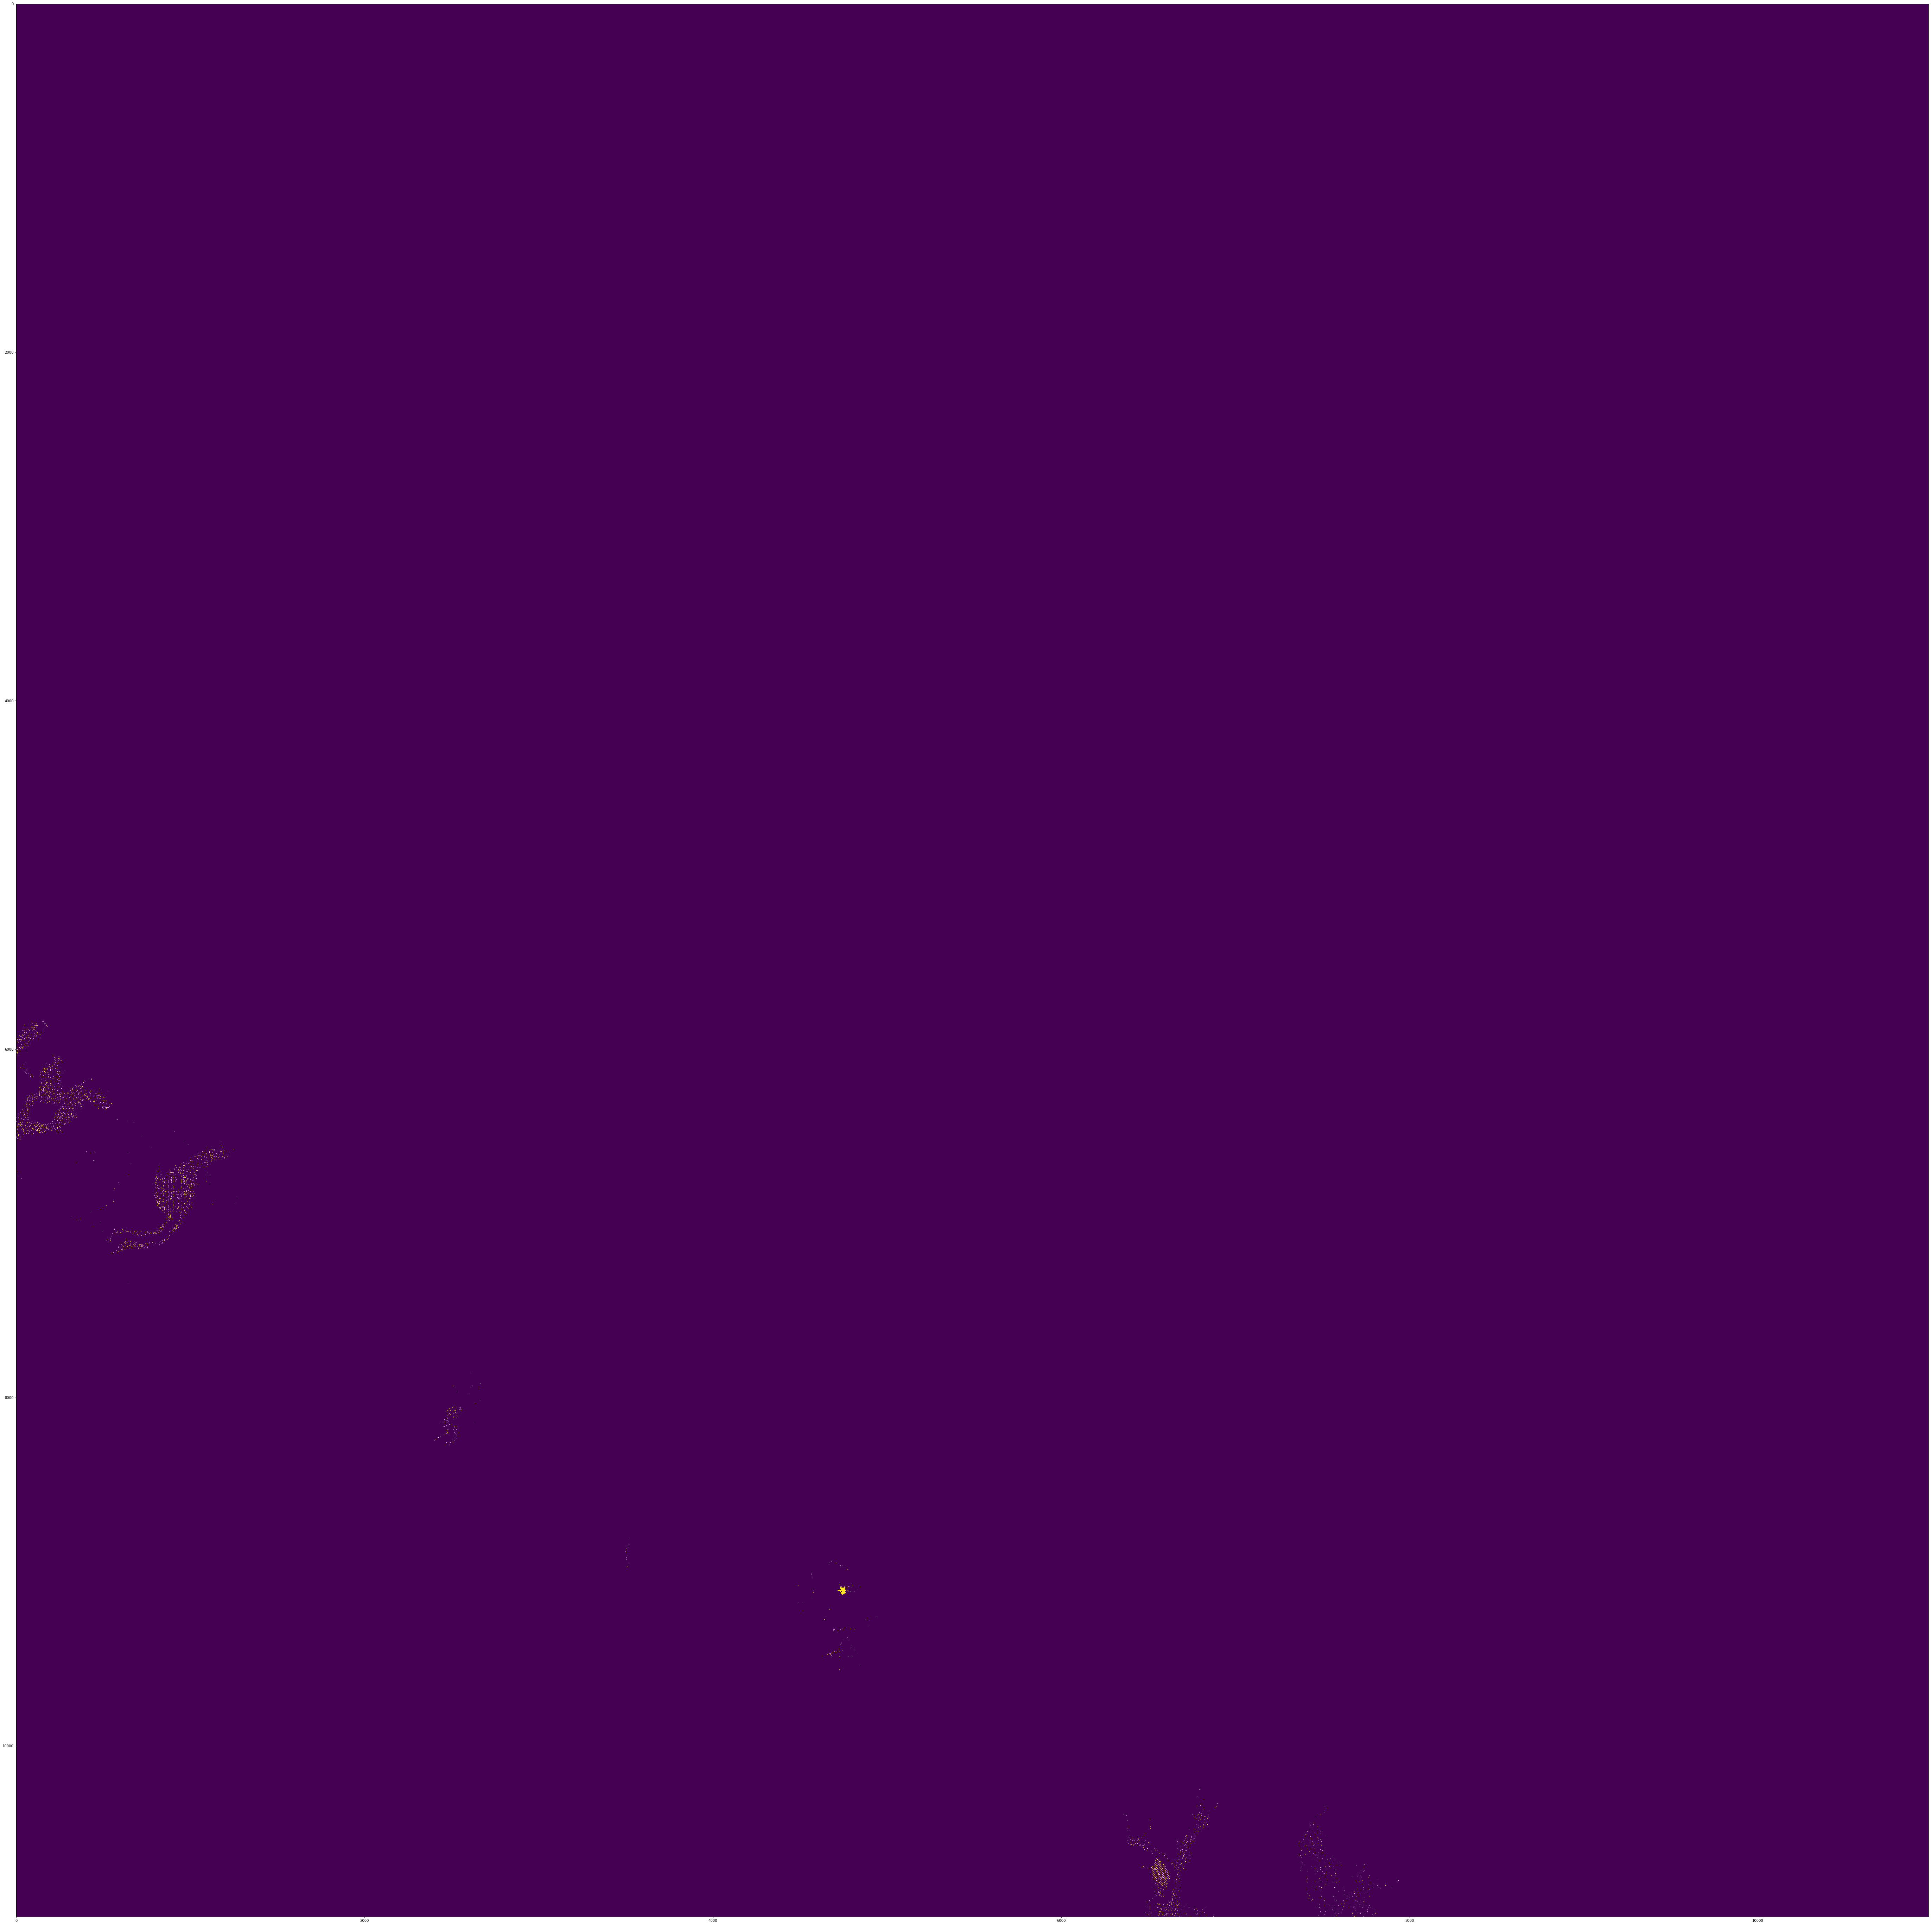

In [23]:
fig = plt.figure(figsize=(100,100))
plt.imshow(ClassifIndex* (SurveyIndex>0))